# Wine quality adathalmaz elemzés

A feladat egy regressziós feladat, ahol a borok tulajdonságai alapján 1-től 10-ig kell osztályozni a borok minőségét.

[Adathalmaz forrása](https://www.kaggle.com/datasets/shilongzhuang/red-and-white-wine-quality)


In [1]:
# Install necessary packages
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from keras.layers import Dense, Input
from keras.models import Sequential
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

## Adatok ismertetése


### Adathalmaz letöltése, beolvasása


In [3]:
# Create data directory if it does not exist
if not os.path.exists("data"):
    os.makedirs("data")

In [4]:
# URLs of the files to be downloaded
urls = [
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names"
]

# Corresponding local file paths
file_paths = [
    "data/winequality-red.csv",
    "data/winequality-white.csv",
    "data/winequality.names"
]

# Download each file if it does not already exist
for url, file_path in zip(urls, file_paths):
    if not os.path.exists(file_path):
        response = requests.get(url)
        response.raise_for_status()  # Ensure we notice bad responses
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {url} to {file_path}")
    else:
        print(f"File {file_path} already exists. Skipping download.")

File data/winequality-red.csv already exists. Skipping download.
File data/winequality-white.csv already exists. Skipping download.
File data/winequality.names already exists. Skipping download.


In [5]:
red = pd.read_csv("data/winequality-red.csv", sep=";")
white = pd.read_csv("data/winequality-white.csv", sep=";")
n = 5
red.tail(n)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [6]:
white.tail(n)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


In [7]:
print("Vörös: ", red.shape)
print("Fehér: ", white.shape)

Vörös:  (1599, 12)
Fehér:  (4898, 12)


Megnézzük, mennyi null érték van az adathalmazokban

In [8]:
print("Vörös: ", red.dropna().shape)
print("Fehér: ", white.dropna().shape)

Vörös:  (1599, 12)
Fehér:  (4898, 12)


Nincsen semennyi null érték, így ezzel nem foglalkoznunk

### Adatelemzés

Megvizsgáljuk, hogy színenként mennyi adat áll rendelkezésre, ha az egyikből jelentősen több, mint a másikból, akkor lehet, jobb egyben kezelni.

In [9]:
print("Vörös: ", red.shape)
print("Fehér: ", white.shape)

Vörös:  (1599, 12)
Fehér:  (4898, 12)


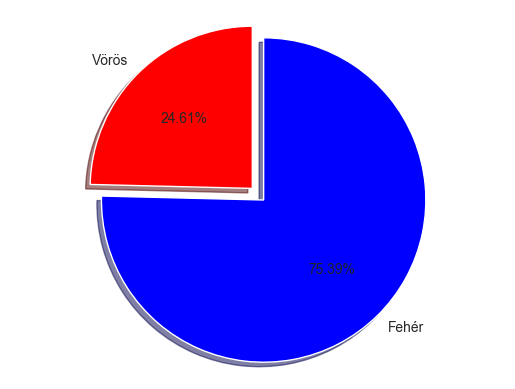

In [10]:
fig1, ax1 = plt.subplots()
ax1.pie((red.shape[0], white.shape[0]), explode=(0, 0.1), labels=('Vörös', 'Fehér'), autopct='%1.2f%%', shadow=True, startangle=90, colors=("red", "blue"))
ax1.axis('equal')
plt.show()

Fehérből több mint háromszor annyi adat van, mint pirosból, így lehet jobb lenne egyben kezelni az adatokat. Hogy ezt megtehetjük-e, ahhoz még megnézzük, hogy mennyire számít a bor színe a minőségébe.

#### Befolyásolja-e a bor színe a bor minőségét?

Felmérjük, hogy mennyi az átlagos minőség az egyes bor színek esetén, és hogy mennyi a korreláció a bor minősge és a bor színe között. Ha alacsony, akkor egyben fogjuk kezelni az adathalmazt.


In [11]:
red_avg = red.quality.sum() / red.quality.count()
white_avg = white.quality.sum() / white.quality.count()
print("Piros borok átlag minősége: ", red_avg)
print("Fehér borok átlag minősége: ", white_avg)

Piros borok átlag minősége:  5.6360225140712945
Fehér borok átlag minősége:  5.87790935075541


Nagyjából ugyan annyi az átlagos minőség a piros és a fehér borok esetében is, így annyira nem számít a bor színe. Megvizsgáljuk a korrelációt is:

In [12]:
red["color"] = 1
white["color"] = 0
data = red._append(white)

In [13]:
data.quality.corr(data.color)

-0.1193232846361132

Ez a korreláció, így emiatt is, meg a tanító adatok számának egyenlőtlen eloszlása miatt is jobb egy adathalmazként kezelni a kettőt. Viszont a korrelációs mátrix alapján a szín a savassággal egész erősen korrelál:

In [14]:
# Calculate the correlation of the given features
print(data["volatile acidity"].corr(data.color))
print(data["fixed acidity"].corr(data.color))

0.6530355891787226
0.4867398320680535


A minőségekből készített hisztogram
Ebből azt következtetjük, hogy a közepesebb minőségű borokból van a legtöbb. Kevés nagyon jó, vagy nagyon rossz minőségű bor van.

Text(0, 0.5, 'Frequency')

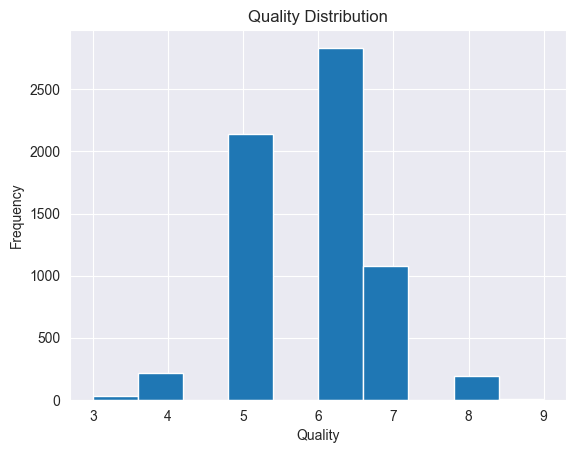

In [15]:
data.quality.hist()
plt.title('Quality Distribution') # Add a title to the plot.
plt.xlabel('Quality') # Add a label to the x-axis.
plt.ylabel('Frequency') # Add a label to the y-axis.

In [16]:
data.quality.value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

Mivel 0, 1, 2 és 10-es minőségű bor nincs az adathalmazban, a modell készítésekor majd kipróbáljuk, mi lenne, ha úgy közelítenénk meg a feladatot, mintha ezek a minőségek nem is léteznének

##### Korrelációs mátrix elemzése

A mátrixból leolvashatjuk, hogy a minőség az alkohol tartalommal, és a sűrűséggel korrelál legerősebben, minél nagyobb alkohol tartalmú, és minél hígabb a bor, annál jobb minőségű.  
Itt még megfigyeltük, hogy viszonylag sok jellemző van, ami nagyon kis mértékben korrelál a minőséggel, ezeket feljegyeztük, és a modell készítésekor megnézzük, mennyire befolyásolja a modellt, ha elhagyunk ilyen oszlopokat.  
Gyengén korreláló oszlopok:
-   fixed acidity
-   citric acid
-   residual sugar
-   free sulfur dioxide
-   total sulfur dioxide
-   pH
-   sulphates

In [17]:
corr = data.corr() # Get the correlation table
corr.style.background_gradient(cmap='coolwarm')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218


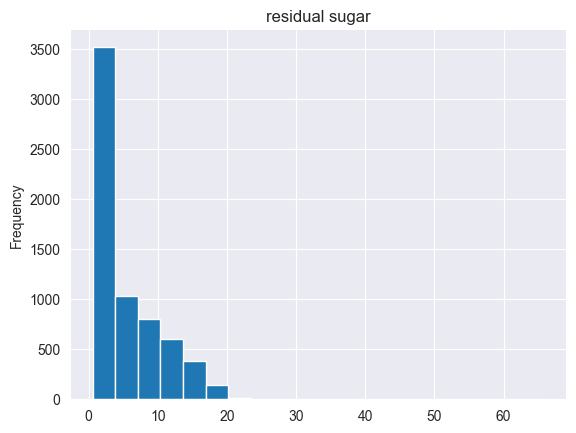

In [18]:
# @title residual sugar

data['residual sugar'].plot(kind='hist', bins=20, title='residual sugar')
plt.gca().spines[['top', 'right',]].set_visible(False)

Now we should store this data so we can use it later in our program.

In [19]:
white_wine_data = pd.read_csv('data/winequality-white.csv', sep = ';')
# Manually OHE if the wine was white or red as it is implicitly in the filename.
white_wine_data['is_white'] = 1
white_wine_data['is_red'] = 0

red_wine_data = pd.read_csv('data/winequality-red.csv', sep = ';')
red_wine_data['is_white'] = 0
red_wine_data['is_red'] = 1

combined_wine_data = white_wine_data._append(red_wine_data)
combined_wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_white,is_red
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,1,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,1,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,1,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0,1
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0,1


In [20]:
combined_wine_data = combined_wine_data.sample(frac = 1) # We shuffle data to have some initial randomness
combined_wine_data.tail(n= 10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_white,is_red
4263,7.0,0.550,0.05,8.0,0.036,19.0,164.0,0.99269,3.26,0.46,12.2,6,1,0
2973,6.6,0.230,0.30,14.9,0.051,33.0,118.0,0.99835,3.04,0.54,9.0,6,1,0
143,6.3,0.390,0.08,1.7,0.066,3.0,20.0,0.99540,3.34,0.58,9.4,5,0,1
1053,8.3,0.330,0.42,2.3,0.070,9.0,20.0,0.99426,3.38,0.77,12.7,7,0,1
3519,6.9,0.330,0.62,7.5,0.038,46.0,132.0,0.99143,3.23,0.43,13.4,7,1,0
3382,6.5,0.280,0.34,3.6,0.040,29.0,121.0,0.99111,3.28,0.48,12.1,7,1,0
3533,6.6,0.220,0.30,14.7,0.045,50.0,136.0,0.99704,3.14,0.37,10.6,6,1,0
4350,7.0,0.360,0.25,5.7,0.015,14.0,73.0,0.98963,2.82,0.59,13.2,6,1,0
647,7.4,0.105,0.34,12.2,0.050,57.0,146.0,0.99730,3.16,0.37,9.0,6,1,0
2738,6.9,0.615,0.42,12.0,0.067,24.0,131.0,0.99727,3.19,0.34,9.3,5,1,0


In [21]:
# Maximum abs scaling
# Copy the data
df_max_scaled = combined_wine_data.copy()

# Apply normalization techniques
for column in df_max_scaled.columns:
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()

corr = df_max_scaled.corr()
corr.style.background_gradient(cmap='coolwarm')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_white,is_red
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,-0.486740,0.486740
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,-0.653036,0.653036
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,0.187397,-0.187397
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,0.348821,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,-0.512678,0.512678
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,0.471644,-0.471644
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,0.700357,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,-0.390645,0.390645
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,-0.329129,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,-0.487218,0.487218


In [22]:
correlations = df_max_scaled.corr()['quality'].drop('quality')  # Calculate correlations with 'quality'
low_correlation_columns = correlations[abs(correlations) <= 0.1].index  # Find low correlation columns
df_max_scaled = df_max_scaled.drop(low_correlation_columns, axis=1)  # Drop low correlation columns
df_max_scaled.tail(n=5)

,volatile acidity,chlorides,density,alcohol,quality,is_white,is_red
3382,0.177215,0.065466,0.953926,0.812081,0.777778,1.0,0.0
3533,0.139241,0.073650,0.959633,0.711409,0.666667,1.0,0.0
4350,0.227848,0.024550,0.952501,0.885906,0.666667,1.0,0.0
647,0.066456,0.081833,0.959884,0.604027,0.666667,1.0,0.0
2738,0.389241,0.109656,0.959855,0.624161,0.555556,1.0,0.0


In [23]:
corr = df_max_scaled.corr()
corr.style.background_gradient(cmap='coolwarm')

,volatile acidity,chlorides,density,alcohol,quality,is_white,is_red
volatile acidity,1.000000,0.377124,0.271296,-0.037640,-0.265699,-0.653036,0.653036
chlorides,0.377124,1.000000,0.362615,-0.256916,-0.200666,-0.512678,0.512678
density,0.271296,0.362615,1.000000,-0.686745,-0.305858,-0.390645,0.390645
alcohol,-0.037640,-0.256916,-0.686745,1.000000,0.444319,0.032970,-0.032970
quality,-0.265699,-0.200666,-0.305858,0.444319,1.000000,0.119323,-0.119323
is_white,-0.653036,-0.512678,-0.390645,0.032970,0.119323,1.000000,-1.000000
is_red,0.653036,0.512678,0.390645,-0.032970,-0.119323,-1.000000,1.000000


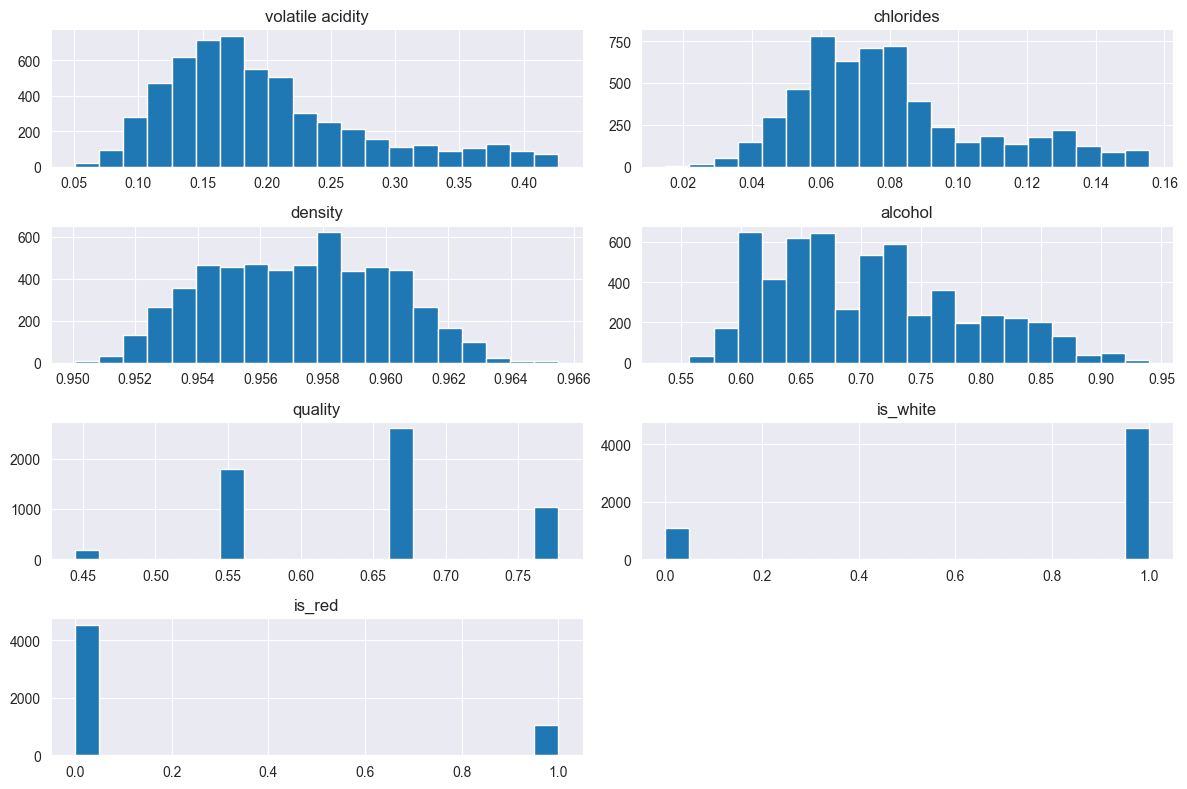

In [24]:
# Calculating Q1, Q3, and IQR
Q1 = df_max_scaled['quality'].quantile(0.25)
Q3 = df_max_scaled['quality'].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = df_max_scaled[(df_max_scaled['quality'] < Q1 - 1.5 * IQR) | (df_max_scaled['quality'] > Q3 + 1.5 * IQR)]

# Removing outliers from the DataFrame
df_no_outliers = df_max_scaled[~((df_max_scaled['quality'] < Q1 - 1.5 * IQR) | (df_max_scaled['quality'] > Q3 + 1.5 * IQR))]

# Calculating Q1, Q3, and IQR
Q1 = df_no_outliers['volatile acidity'].quantile(0.25)
Q3 = df_no_outliers['volatile acidity'].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = df_no_outliers[(df_no_outliers['volatile acidity'] < Q1 - 1.5 * IQR) | (df_no_outliers['volatile acidity'] > Q3 + 1.5 * IQR)]

# Removing outliers from the DataFrame
df_no_outliers = df_no_outliers[~((df_no_outliers['volatile acidity'] < Q1 - 1.5 * IQR) | (df_no_outliers['volatile acidity'] > Q3 + 1.5 * IQR))]

# Calculating Q1, Q3, and IQR
Q1 = df_no_outliers['chlorides'].quantile(0.25)
Q3 = df_no_outliers['chlorides'].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = df_no_outliers[(df_no_outliers['chlorides'] < Q1 - 1.5 * IQR) | (df_no_outliers['chlorides'] > Q3 + 1.5 * IQR)]

# Removing outliers from the DataFrame
df_no_outliers = df_no_outliers[~((df_no_outliers['chlorides'] < Q1 - 1.5 * IQR) | (df_no_outliers['chlorides'] > Q3 + 1.5 * IQR))]

# Calculating Q1, Q3, and IQR
Q1 = df_no_outliers['density'].quantile(0.25)
Q3 = df_no_outliers['density'].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = df_no_outliers[(df_no_outliers['density'] < Q1 - 1.5 * IQR) | (df_no_outliers['density'] > Q3 + 1.5 * IQR)]

# Removing outliers from the DataFrame
df_no_outliers = df_no_outliers[~((df_no_outliers['density'] < Q1 - 1.5 * IQR) | (df_no_outliers['density'] > Q3 + 1.5 * IQR))]

# Calculating Q1, Q3, and IQR
Q1 = df_no_outliers['alcohol'].quantile(0.25)
Q3 = df_no_outliers['alcohol'].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = df_no_outliers[(df_no_outliers['alcohol'] < Q1 - 1.5 * IQR) | (df_no_outliers['alcohol'] > Q3 + 1.5 * IQR)]

# Removing outliers from the DataFrame
df_no_outliers = df_no_outliers[~((df_no_outliers['alcohol'] < Q1 - 1.5 * IQR) | (df_no_outliers['alcohol'] > Q3 + 1.5 * IQR))]

# Plot the data points after removing outliers
df_no_outliers.hist(figsize=(12, 8), layout=(4, 2), bins=20)  # You can change layout depending on the number of histograms.
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

In [25]:
print(f"{len(df_max_scaled)-len(df_no_outliers)} items were removed from the dataset based on quality outliers of the 75th percentile.")

878 items were removed from the dataset based on quality outliers of the 75th percentile.


In [26]:
corr = df_no_outliers.corr()
corr.style.background_gradient(cmap='coolwarm')

,volatile acidity,chlorides,density,alcohol,quality,is_white,is_red
volatile acidity,1.000000,0.475243,0.218824,-0.005374,-0.210946,-0.603400,0.603400
chlorides,0.475243,1.000000,0.542070,-0.331628,-0.203118,-0.735775,0.735775
density,0.218824,0.542070,1.000000,-0.724691,-0.281698,-0.341629,0.341629
alcohol,-0.005374,-0.331628,-0.724691,1.000000,0.431509,0.000498,-0.000498
quality,-0.210946,-0.203118,-0.281698,0.431509,1.000000,0.041223,-0.041223
is_white,-0.603400,-0.735775,-0.341629,0.000498,0.041223,1.000000,-1.000000
is_red,0.603400,0.735775,0.341629,-0.000498,-0.041223,-1.000000,1.000000


# **Classification** **problem**

In [27]:
classification_data = df_no_outliers.copy()
quality_mean = classification_data["quality"].mean()

In [28]:
print(quality_mean)

0.645152360048249


In [29]:
classification_data.loc[classification_data["quality"] < quality_mean, "quality"] = 0
classification_data.loc[classification_data["quality"] >= quality_mean, "quality"] = 1

In [30]:
classification_data.head(10)

,volatile acidity,chlorides,density,alcohol,quality,is_white,is_red
3286,0.145570,0.076923,0.954070,0.731544,1.0,1.0,0.0
4452,0.246835,0.078560,0.955784,0.657718,0.0,1.0,0.0
2933,0.139241,0.047463,0.955995,0.724832,1.0,1.0,0.0
2207,0.145570,0.073650,0.954975,0.758389,1.0,1.0,0.0
1847,0.278481,0.080196,0.960557,0.604027,0.0,1.0,0.0
744,0.240506,0.067103,0.958007,0.671141,0.0,1.0,0.0
1252,0.155063,0.076923,0.955456,0.624161,1.0,1.0,0.0
385,0.208861,0.044190,0.952184,0.838926,1.0,1.0,0.0
4317,0.215190,0.062193,0.952184,0.818792,1.0,1.0,0.0
3927,0.139241,0.075286,0.953801,0.771812,0.0,1.0,0.0


In [31]:
train_features, test_features, train_labels, test_labels = train_test_split(classification_data.drop(columns=["quality"]), classification_data.quality, test_size=0.2)
test_features, validate_features, test_labels, validate_labels = train_test_split(test_features, test_labels, test_size=0.5)

In [32]:
train_features.head(10)

,volatile acidity,chlorides,density,alcohol,is_white,is_red
1754,0.101266,0.068740,0.954205,0.744966,1.0,0.0
3250,0.082278,0.070376,0.954417,0.758389,1.0,0.0
3266,0.151899,0.049100,0.956775,0.791946,1.0,0.0
1784,0.151899,0.062193,0.955938,0.778523,1.0,0.0
4581,0.170886,0.062193,0.954061,0.744966,1.0,0.0
205,0.189873,0.155483,0.961905,0.724832,0.0,1.0
3035,0.151899,0.042553,0.952992,0.758389,1.0,0.0
4211,0.240506,0.067103,0.958864,0.671141,1.0,0.0
985,0.367089,0.104746,0.958267,0.758389,0.0,1.0
1794,0.234177,0.104746,0.957285,0.630872,1.0,0.0


In [33]:
train_labels.head(10)

1754    1.0
3250    1.0
3266    1.0
1784    1.0
4581    1.0
205     1.0
3035    1.0
4211    1.0
985     1.0
1794    0.0
Name: quality, dtype: float64

**Baseline** **solution**

In [34]:
classification_data['quality'].value_counts()

quality
1.0    3656
0.0    1963
Name: count, dtype: int64

In [35]:
mode = classification_data["quality"].mode()
prediction = [mode for _ in test_features.index]
conf_mat = confusion_matrix(prediction, test_labels)
acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
print('Overall accuracy: {}%'.format(acc*100))

Overall accuracy: 59.7864768683274%


 **Better** **solution**

In [36]:
# Initialize the model
classification_model = Sequential()

# Add input layer and first hidden layer
classification_model.add(Input(shape=(len(train_features.iloc[0]),)))
classification_model.add(Dense(32, activation='relu'))

# Add the second hidden layer
classification_model.add(Dense(32, activation='relu'))

# Add the output layer
classification_model.add(Dense(1, activation='sigmoid'))

# Print the model summary
classification_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
classification_model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [38]:
hist = classification_model.fit(x= train_features, y = train_labels, epochs= 500, batch_size=100, validation_data = (validate_features, validate_labels)) # Train

Epoch 1/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4227 - loss: 0.7311 - val_accuracy: 0.6762 - val_loss: 0.6295
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6588 - loss: 0.6376 - val_accuracy: 0.6762 - val_loss: 0.6254
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6556 - loss: 0.6364 - val_accuracy: 0.6762 - val_loss: 0.6230
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6491 - loss: 0.6388 - val_accuracy: 0.6762 - val_loss: 0.6204
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6598 - loss: 0.6282 - val_accuracy: 0.6762 - val_loss: 0.6184
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6574 - loss: 0.6258 - val_accuracy: 0.6762 - val_loss: 0.6120
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6537 - loss: 0.6228 - val_accuracy: 0.6762 - val_loss: 0.6059
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6555 - loss: 0.6144 - val_accuracy: 0.6762 - v

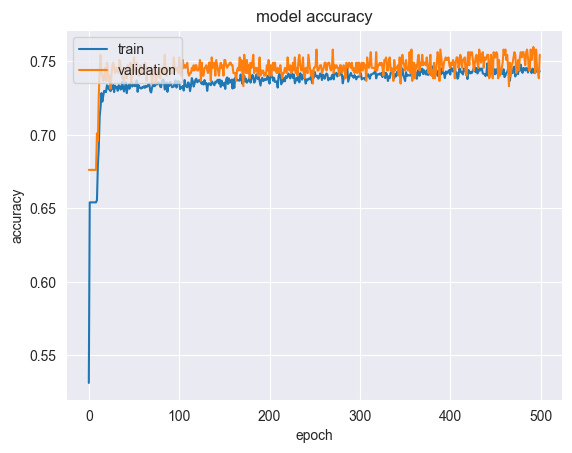

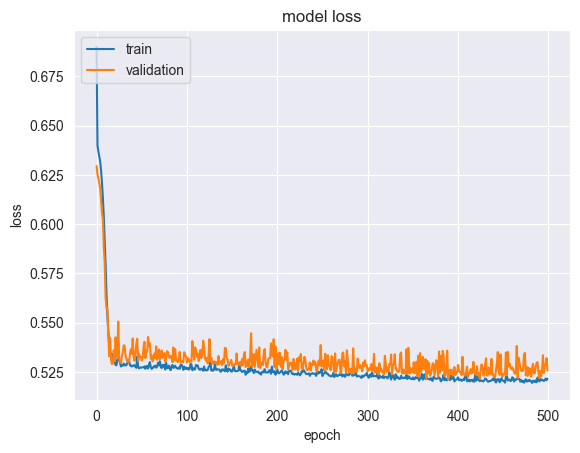

In [39]:
legend = ['train', 'validation']

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.show()

In [40]:
classification_model.evaluate(test_features, test_labels, verbose = 1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.7286 - loss: 0.5542


[0.5781912207603455, 0.7153024673461914]

ReLU is probably good as there are mostly positives values.

In [41]:
# Define your classifiers
RF = RandomForestClassifier(random_state=42)  # Add any parameters you wish to tune
GBC = GradientBoostingClassifier(random_state=42)  # Add any parameters you wish to tune

META_RF = RandomForestClassifier(random_state=42)

# Now you can define your stacking classifier
sclf = StackingClassifier(classifiers=[RF, GBC],
                          use_probas=False,
                          average_probas=False,
                          use_features_in_secondary=False,
                          meta_classifier=META_RF)

# Fit the stacking classifier to your training data
sclf.fit(X=train_features, y=train_labels)

StackingClassifier(classifiers=[RandomForestClassifier(random_state=42),
                                GradientBoostingClassifier(random_state=42)],
                   meta_classifier=RandomForestClassifier(random_state=42))

Accuracy: 0.78
              precision    recall  f1-score   support

        good       0.78      0.64      0.70       226
         bad       0.78      0.88      0.83       336

    accuracy                           0.78       562
   macro avg       0.78      0.76      0.77       562
weighted avg       0.78      0.78      0.78       562



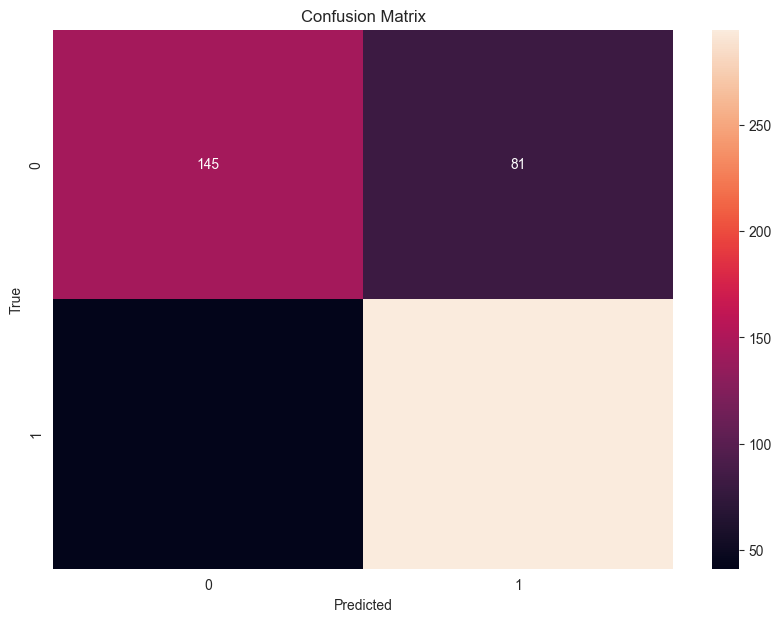

In [42]:
# Predict on the test set
test_predictions = sclf.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy: {accuracy:.2f}')

# Print out the classification report for precision, recall, and F1 score
print(classification_report(test_labels, test_predictions, target_names=["good", "bad"]))

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Further advancements

The following advancements will be made to try and explore new data and a different model:

- I will create polynomial features to possibly capture nonlinear relations in the data.
- Then, I will feed this into a stacked classifier, which handles non-linearity better as well, while handling overfitting better.

In [43]:
from sklearn.preprocessing import PolynomialFeatures

# Separate the continuous and categorical features
continuous_features_train = train_features.drop(columns=['is_white', 'is_red'])
categorical_features_train = train_features[['is_white', 'is_red']]

continuous_features_test = test_features.drop(columns=['is_white', 'is_red'])
categorical_features_test = test_features[['is_white', 'is_red']]


# Initialize PolynomialFeatures with the desired degree (e.g., 2 for quadratic features)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform the continuous features to create polynomial features
continuous_features_train_poly = poly.fit_transform(continuous_features_train)
continuous_features_test_poly = poly.fit_transform(continuous_features_test)

# Get feature names for the new polynomial features
continuous_feature_train_names = poly.get_feature_names_out(input_features=continuous_features_train.columns)
continuous_feature_test_names = poly.get_feature_names_out(input_features=continuous_features_test.columns)

# Create a DataFrame with the new polynomial features
continuous_features_train_poly_df = pd.DataFrame(continuous_features_train_poly, columns=continuous_feature_train_names)
continuous_features_test_poly_df = pd.DataFrame(continuous_features_test_poly, columns=continuous_feature_test_names)

# Concatenate the transformed continuous features with the original categorical features
train_features_train_poly_df = pd.concat([continuous_features_train_poly_df, categorical_features_train.reset_index(drop=True)], axis=1)
test_features_test_poly_df = pd.concat([continuous_features_test_poly_df, categorical_features_test.reset_index(drop=True)], axis=1)

# Display the first few rows to verify
print(train_features_train_poly_df.head())

# Print the column names
print(train_features_train_poly_df.columns)

   volatile acidity  chlorides   density   alcohol  volatile acidity^2  \
0          0.101266   0.068740  0.954205  0.744966            0.010255   
1          0.082278   0.070376  0.954417  0.758389            0.006770   
2          0.151899   0.049100  0.956775  0.791946            0.023073   
3          0.151899   0.062193  0.955938  0.778523            0.023073   
4          0.170886   0.062193  0.954061  0.744966            0.029202   

   volatile acidity chlorides  volatile acidity density  \
0                    0.006961                  0.096628   
1                    0.005790                  0.078528   
2                    0.007458                  0.145333   
3                    0.009447                  0.145206   
4                    0.010628                  0.163036   

   volatile acidity alcohol  chlorides^2  chlorides density  \
0                  0.075440     0.004725           0.065592   
1                  0.062399     0.004953           0.067168   
2          

In [44]:
from xgboost import XGBClassifier   

# Define your classifiers
XGB = XGBClassifier(random_state=42)
RF = RandomForestClassifier(random_state=42)  # Add any parameters you wish to tune
GBC = GradientBoostingClassifier(random_state=42)  # Add any parameters you wish to tune

META_XGB = RandomForestClassifier(random_state=42)

# Now you can define your stacking classifier
sclf_upgraded = StackingClassifier(classifiers=[RF, GBC, XGB],
                          use_probas=False,
                          average_probas=False,
                          use_features_in_secondary=False,
                          meta_classifier=META_XGB)
# Fit the stacking classifier to your training data
sclf_upgraded.fit(X=train_features_train_poly_df, y=train_labels)

StackingClassifier(classifiers=[RandomForestClassifier(random_state=42),
                                GradientBoostingClassifier(random_state=42),
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=Non...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)],
                   meta_classifier=RandomForestClassifier(random_state=42))

In [45]:
# Predict on the test set
test_predictions_upgraded = sclf_upgraded.predict(test_features_test_poly_df)

# Calculate accuracy
accuracy_upgraded = accuracy_score(test_labels, test_predictions_upgraded)
print(f'Accuracy: {accuracy_upgraded:.2f}')

# Print out the classification report for precision, recall, and F1 score
print(classification_report(test_labels, test_predictions, target_names=["good", "bad"]))

# Generate and print the upgraded confusion matrix
conf_matrix_upgraded = confusion_matrix(test_labels, test_predictions_upgraded)

# Print out the upgraded classification report for precision, recall, and F1 score
print(classification_report(test_labels, test_predictions, target_names=["good", "bad"]))

Accuracy: 0.78
              precision    recall  f1-score   support

        good       0.78      0.64      0.70       226
         bad       0.78      0.88      0.83       336

    accuracy                           0.78       562
   macro avg       0.78      0.76      0.77       562
weighted avg       0.78      0.78      0.78       562

              precision    recall  f1-score   support

        good       0.78      0.64      0.70       226
         bad       0.78      0.88      0.83       336

    accuracy                           0.78       562
   macro avg       0.78      0.76      0.77       562
weighted avg       0.78      0.78      0.78       562



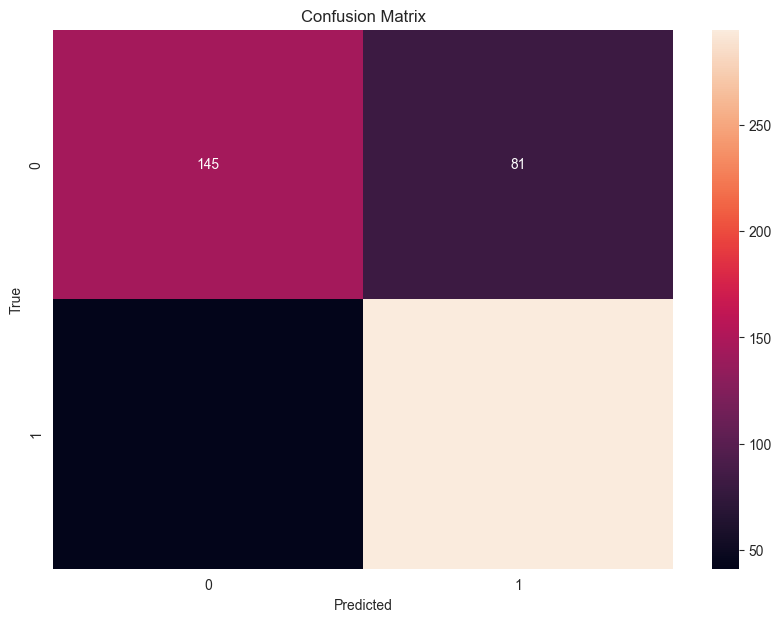

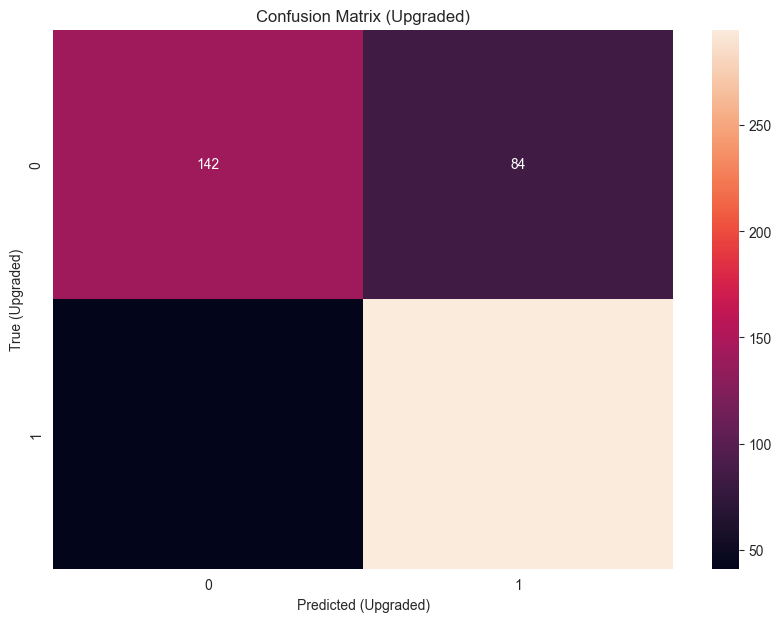

In [46]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_upgraded, annot=True, fmt='d')
plt.xlabel('Predicted (Upgraded)')
plt.ylabel('True (Upgraded)')
plt.title('Confusion Matrix (Upgraded)')
plt.show()

Ez összességében aligha változtatott valamit, de sikeresen megvizsgáltunk egy új architectúrát és generáltunk új jellemzőket. Ebből azt lehet levonni, hogy a nemlineáris kapcsolatok nem játszanak szerepet a minőségben, ezért egyszerűbb modellekkel is dolgozhatunk.